In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# read in all the words
words = open('makemore_dataset/things to eat.txt', 'r').read().lower().replace("'", '').replace('-', ' ').splitlines()
words[:8]

['turkeys',
 'pink beans',
 'half and half',
 'ice cream',
 'mushrooms',
 'aquavit',
 'cookies',
 'chives']

In [3]:
sorted(list(set(''.join(words))))

[' ',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z']

In [4]:
# map each character to an index for one-hot encoding
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0

itos = {i:s for s, i in stoi.items()}
vocab_size = len(itos)

In [5]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([8085, 3]) torch.Size([8085])
torch.Size([1042, 3]) torch.Size([1042])
torch.Size([1017, 3]) torch.Size([1017])


#### Pytorch-API nn


In [6]:
# Let's train a deeper network
# The classes we create here are the same API as nn.Module in PyTorch
g = torch.Generator().manual_seed(2147483647) # for reproducibility

class Linear:
  
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
    self.bias = torch.zeros(fan_out) if bias else None
  
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      xmean = x.mean(0, keepdim=True) # batch mean
      xvar = x.var(0, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]

class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

In [7]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd),            generator=g)
layers = [
  Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
]
# layers = [
#   Linear(n_embd * block_size, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, vocab_size),
# ]

with torch.no_grad():
  # last layer: make less confident
  layers[-1].gamma *= 0.1
  #layers[-1].weight *= 0.1
  # all other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 1.0 #5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

47136


In [27]:
# same optimization as last time
max_steps = 2000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function
  
  # backward pass
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

  #if i >= 1000:
    #break # AFTER_DEBUG: would take out obviously to run full optimization

      0/   2000: 0.7748


#### Pytorch stats

layer 2 (      Tanh): mean +0.00, std 0.69, saturated: 15.66%
layer 5 (      Tanh): mean +0.00, std 0.73, saturated: 16.78%
layer 8 (      Tanh): mean -0.00, std 0.76, saturated: 17.31%
layer 11 (      Tanh): mean -0.01, std 0.78, saturated: 16.97%
layer 14 (      Tanh): mean -0.02, std 0.79, saturated: 20.31%


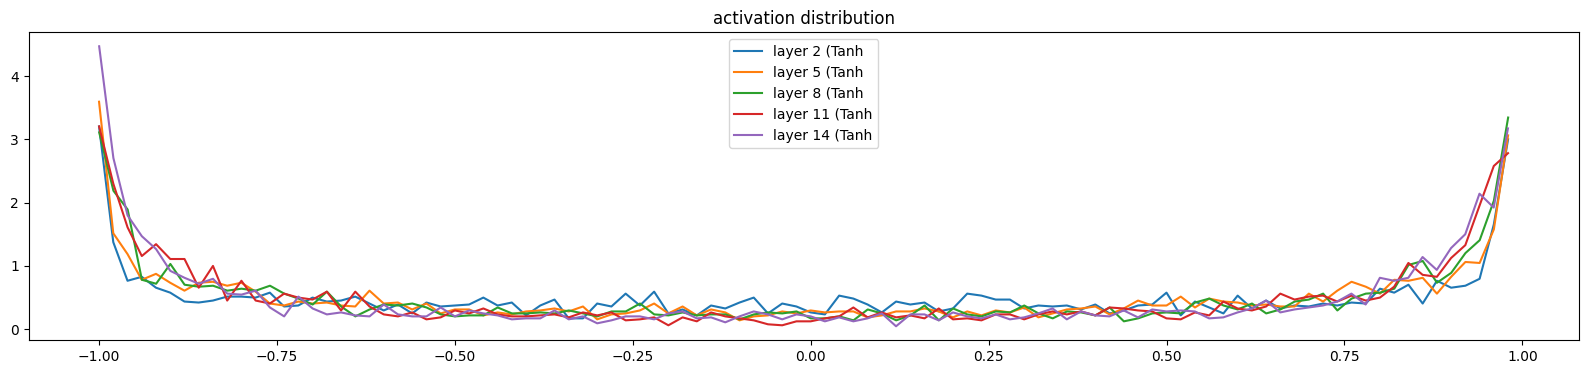

In [28]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.cpu()
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution');

layer 2 (      Tanh): mean +0.000000, std 4.337515e-03
layer 5 (      Tanh): mean -0.000000, std 4.581786e-03
layer 8 (      Tanh): mean -0.000000, std 5.053535e-03
layer 11 (      Tanh): mean -0.000000, std 4.524958e-03
layer 14 (      Tanh): mean -0.000000, std 5.157609e-03


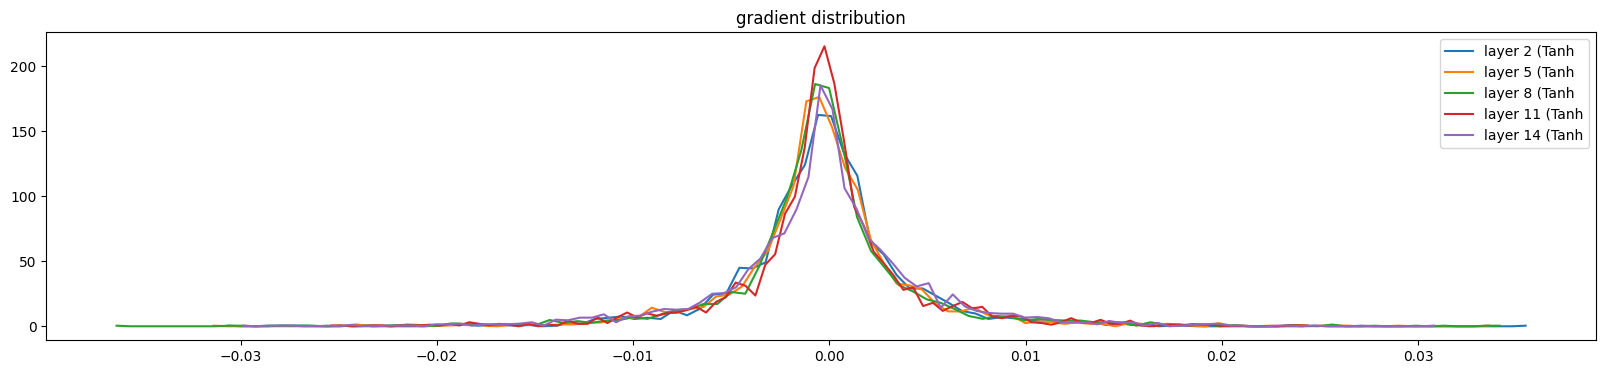

In [31]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad.cpu()
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution');

weight   (28, 10) | mean -0.000000 | std 1.795222e-02 | grad:data ratio 1.665313e-02
weight  (30, 100) | mean -0.000284 | std 1.255813e-02 | grad:data ratio 3.791147e-02
weight (100, 100) | mean +0.000053 | std 8.350390e-03 | grad:data ratio 4.144846e-02
weight (100, 100) | mean -0.000081 | std 8.676502e-03 | grad:data ratio 4.333256e-02
weight (100, 100) | mean -0.000074 | std 8.487372e-03 | grad:data ratio 4.378732e-02
weight (100, 100) | mean -0.000091 | std 7.148834e-03 | grad:data ratio 3.939872e-02
weight  (100, 28) | mean +0.000109 | std 1.333020e-02 | grad:data ratio 4.610096e-02


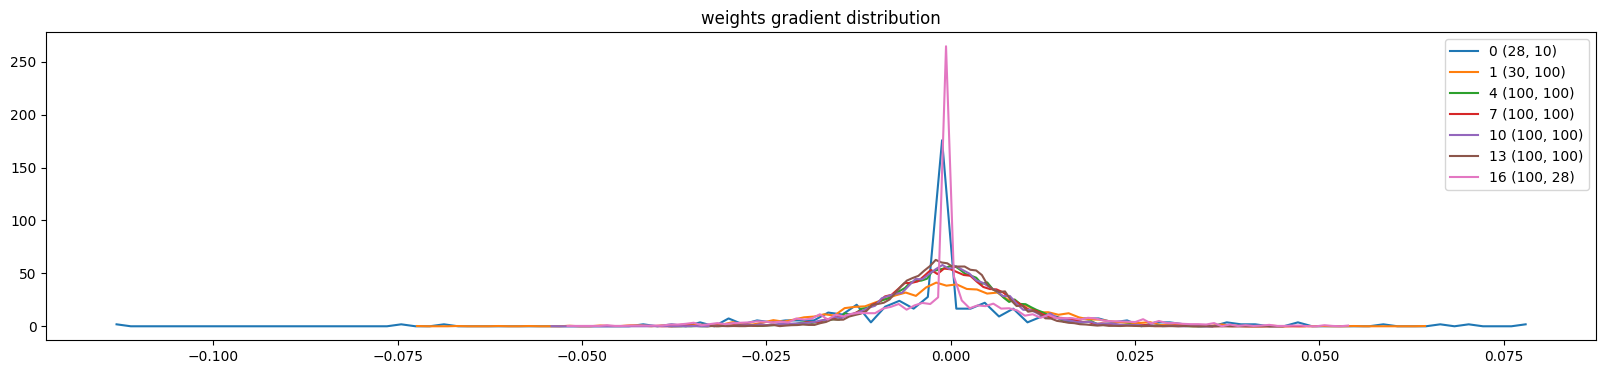

In [32]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad.cpu()
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

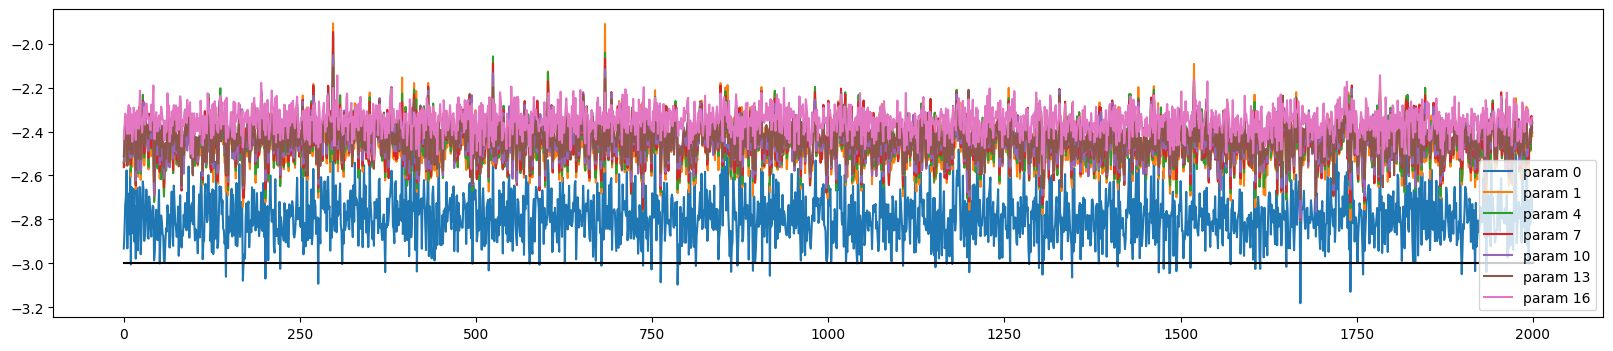

In [33]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);


In [34]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      emb = C[torch.tensor([context])] # (1,block_size,n_embd)
      x = emb.view(emb.shape[0], -1) # concatenate the vectors
      for layer in layers:
        x = layer(x)
      logits = x
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

C:\Users\arthu\AppData\Local\Temp\ipykernel_2116\1028192721.py:38: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  xvar = x.var(0, keepdim=True) # batch variance


RuntimeError: probability tensor contains either `inf`, `nan` or element < 0

#### Manually implemented nn

In [ ]:
g = torch.Generator().manual_seed(11)
n_embd = 10
n_hidden = 200

# vector embeddings
C = torch.randn((vocab_size, n_embd), generator=g)

# 3*10 incoming weights for 200 neurons
W1 = torch.randn((n_embd*block_size, n_hidden), generator=g) * 0.2
b1 = torch.randn(n_hidden, generator=g) * 0.01

# 200 incoming weights for 27 neurons
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0.01

# BatchNorm parameters
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
for p in parameters:
    p.requires_grad = True
print(sum([p.nelement() for p in parameters]))

12297


In [35]:
# decide on training, validation, or test inputs
X = Xtr
Y = Ytr

# hyperparameters
epoch = 15000
lrs = torch.linspace(-3, -3, epoch)
s_minibatch = 40

# track statistics
lossi = []

for i in range(epoch):

    # minibatch creation
    ix = torch.randint(0, X.shape[0], (s_minibatch, ), generator=g)

    # batch for X and Y
    Xb = X[ix]
    Yb = Y[ix]

    # forward pass
    emb = C[Xb]
    hpreact = emb.view(emb.shape[0], -1) @ W1 + b1
      
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)

    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi

    hpreact = (hpreact - bnmeani) / bnstdi 
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)

    # backward pass
    for p in parameters:
        p.grad = None

    loss.backward()

    # update parameters
    lr = 10 ** lrs[i]

    for p in [C, W1, b1, W2, b2]:
        p.data += -lr * p.grad

    # track stats
    lossi.append(loss.item())

print(loss.item())



2.648632764816284


#### Manual nn Stats

In [22]:
# 1 concatenated input consisting of <block_size> concatenated <n_embd> dimensional embedding vectors
emb.view(emb.shape[0], -1)[0].shape

torch.Size([30])

$x = [x1, x2, ..., xn] \in R^n$

In [23]:
# 1st hidden layer
W1.shape, b1.shape

(torch.Size([30, 200]), torch.Size([200]))

In [24]:
# output from first layer + activation function
h.shape

torch.Size([40, 200])

In [25]:
W2.shape

torch.Size([200, 27])

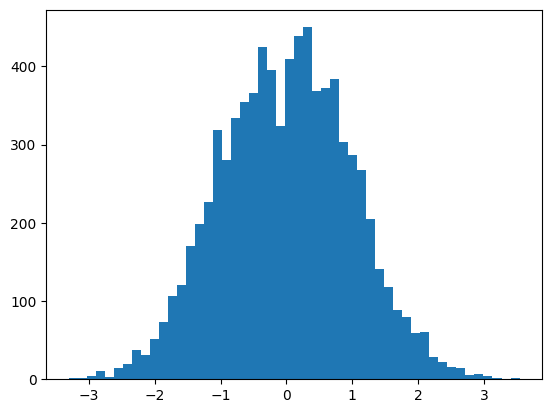

In [26]:
plt.hist(hpreact.view(-1).tolist(), 50);

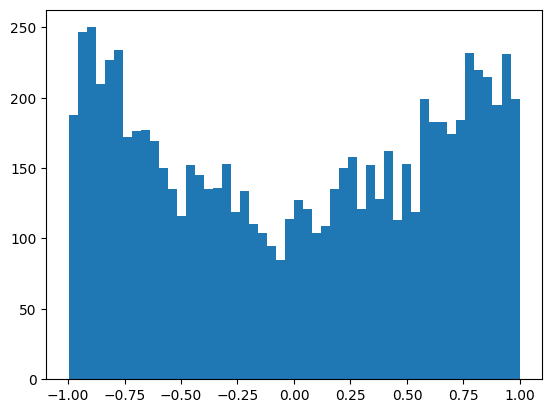

In [27]:
# information loss through oversaturated activation function tanh()
# looking at the derivative of tanh w.r.t any weight of the input, gradients are destroyed/ passed through
plt.hist(h.view(-1).tolist(), 50);

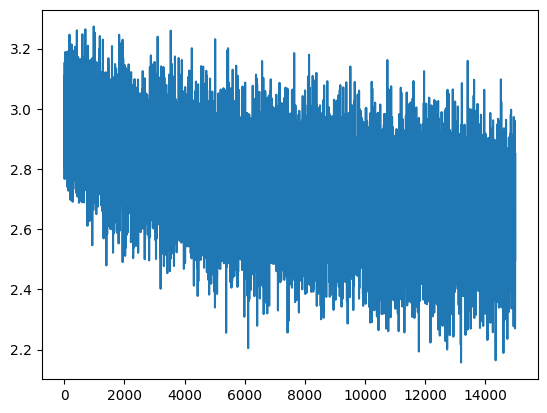

In [28]:
plt.plot(list(range(epoch)), lossi)

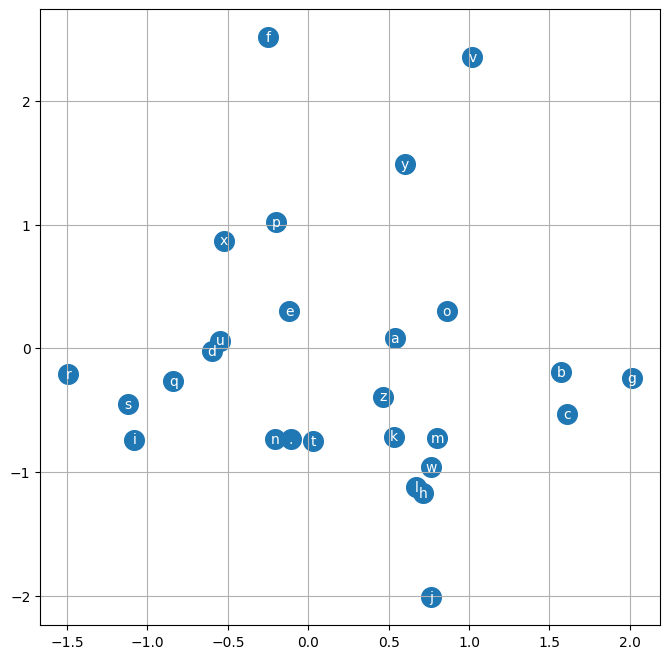

In [37]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].cpu().data, C[:,1].cpu().data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [29]:
# calibrate the batch norm at the end of training

with torch.no_grad():
  # pass the training set through
  emb = C[Xtr]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 # + b1
  # measure the mean/std over the entire training set
  bnmean = hpreact.mean(0, keepdim=True)
  bnstd = hpreact.std(0, keepdim=True)
bnmean.shape, bnstd.shape

(torch.Size([1, 200]), torch.Size([1, 200]))

In [30]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]

  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 + b1
  #hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
  #hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

In [76]:
# with batch normalising of initial loss and fixing saturated tanh
split_loss('train') # 2.24
split_loss('val') # 2.25

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [32]:
# with standard forward pass
split_loss('train') # 2.077
split_loss('val') # 2.14

train 2.7619590759277344
val 2.764399290084839


In [77]:
# sample from the model

# sampling 20 words
for _ in range(20):
    # array to store output indices
    out = []
    # start with empty context
    context =  [0] * block_size

    while True:
        # index into embedding vectors with each index in context
        vec = C[torch.tensor([context])]

        # pass concatenated embedding vectors through first hidden layer and activation function
        h = torch.tanh(vec.view(vec.shape[0], -1) @ W1 + b1) 

        # turn output logits into probability distribution
        logits = h @ W2 + b2 # (N, vocab_size)
        counts = logits.exp()
        probs = counts / counts.sum(1, keepdim=True)

        # sample from indexed probability distribution for next index
        next_index = torch.multinomial(probs, num_samples=1, replacement=True).item()

        # update context window
        context = context[1:] + [next_index]
        out.append(next_index)
        
        # finish generation of word when stopping character is outputted
        if next_index == 0:
            break
    print(''.join(itos[i] for i in out))


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.
